

| **TCP/IP-Schicht**    | **Protokoll**  | **Scapy-Objekt**                 |
| --------------------- | -------------- | -------------------------------- |
| **Link Layer**        | Ethernet       | `Ether()`                        |
|                       | Wi-Fi (802.11) | `Dot11()`                        |
|                       | ARP            | `ARP()`                          |
| **Internet Layer**    | IP             | `IP()`                           |
|                       | IPv6           | `IPv6()`                         |
|                       | ICMP           | `ICMP()`                         |
| **Transport Layer**   | TCP            | `TCP()`                          |
|                       | UDP            | `UDP()`                          |
|                       | SCTP           | `SCTP()`                         |
| **Application Layer** | HTTP           | `Raw()` (mit `IP()` und `TCP()`) |
|                       | DNS            | `DNS()`, `DNSQR()`, `DNSRR()`    |
|                       | FTP            | `Raw()` (mit `IP()` und `TCP()`) |
|                       | SMTP           | `Raw()` (mit `IP()` und `TCP()`) |




| Methode        | Beschreibung                                                                                                                                                                               |     |
| -------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --- |
| `send()`       | Sendet Pakete auf Layer 3 (Netzwerkschicht). Beispiel: `send(IP(dst="1.1.1.1")/ICMP())`                                                                                                    |     |
| `sendp()`      | Sendet Pakete auf Layer 2 (Datenverbindungsschicht). Beispiel: `sendp(Ether()/IP(dst="1.1.1.1")/ICMP())`                                                                                   |     |
| `sr()`         | Sendet und empfängt Pakete auf Layer 3. Beispiel: `sr(IP(dst="1.1.1.1")/ICMP())`                                                                                                           |     |
| `sr1()`        | Sendet ein Paket und empfängt die erste Antwort auf Layer 3. Beispiel: `sr1(IP(dst="1.1.1.1")/ICMP())`                                                                                     |     |
| `srp()`        | Sendet und empfängt Pakete auf Layer 2. Beispiel: `srp(Ether()/IP(dst="1.1.1.1")/ICMP())`                                                                                                  |     |
| `srp1()`       | Sendet ein Paket und empfängt die erste Antwort auf Layer 2. Beispiel: `srp1(Ether()/IP(dst="1.1.1.1")/ICMP())`                                                                            |     |
| `sniff()`      | Fängt Pakete ab und kann mit einem Filter und einer Callback-Funktion verwendet werden. Beispiel: `sniff(filter="icmp", prn=lambda x: x.show())`                                           |     |
| `traceroute()` | Führt eine Traceroute durch und zeigt den Weg zu einem Ziel. Beispiel: `traceroute("1.1.1.1")`                                                                                             |     |
| `arping()`     | Sendet ARP-Anfragen, um Geräte im Netzwerk zu entdecken. Beispiel: `arping("192.168.1.0/24")`                                                                                              |     |
| `sendrecv()`   | Eine generische Methode, die `sr()`, `sr1()`, `srp()`, und `srp1()` vereint und basierend auf den Parametern die passende Methode auswählt. Beispiel: `sendrecv(IP(dst="1.1.1.1")/ICMP())` |     |



In [ ]:
from scapy.layers.inet import *
from scapy.all import *

sr1(IP(dst="8.8.8.8")/ICMP()).show()

In [ ]:
# Senden eines Pakets ohne auf eine Antwort zu warten
send(IP(dst="8.8.8.8")/ICMP())

# Senden eines Pakets und Empfangen der Antwort
ans, unans = sr(IP(dst="8.8.8.8")/ICMP())
ans.summary()

# Live Demo - iPhone anpingen im lokalen Netzwerk (über USB und Hotspot)

### 1. ARP-Request senden (um MAC-Adresse des iPhones zu ermitteln)

In [ ]:
from scapy.layers.l2 import ARP
from scapy.all import *

# Ziel-IP-Adresse deines iPhones
target_ip = "172.20.10.1"

# WLAN-Schnittstelle auf Windows
interface = "Wi-Fi"  # Name der WLAN-Schnittstelle

# ARP Anfrage erstellen
arp_request = ARP(pdst=target_ip)
ether = Ether(dst="ff:ff:ff:ff:ff:ff")
arp_packet = ether / arp_request

# Senden und Empfangen der Antwort
answered, unanswered = srp(arp_packet, iface=interface, timeout=2)

# Ergebnisse anzeigen
if answered:
    for snd, rcv in answered:
        print(f"IP-Adresse: {rcv.psrc} hat MAC-Adresse: {rcv.hwsrc}")
        iphone_mac = rcv.hwsrc
else:
    print("Keine Antwort erhalten")


### 2. ICMP-Paket senden (um zu überprüfen, ob das iPhone erreichbar ist)

In [ ]:
from scapy.layers.dot11 import Dot11
from scapy.all import *

# Ziel-IP-Adresse deines iPhones
target_ip = "172.20.10.1"
target_mac = "92:ec:ea:4c:51:64"

# IP und ICMP Schicht erstellen
ip = IP(dst=target_ip)
icmp = ICMP()

# Schichten zusammenfügen
#packet = ip / icmp
packet = Ether(dst=target_mac) / ip / icmp

packet.show()

# Paket senden (wartet auf eine Antwort für 2 Sekunden)
response = sr1(packet, timeout=5, iface="Wi-Fi")

# Überprüfe, ob eine Antwort empfangen wurde
if response:
    response.show()
else:
    print("Keine Antwort erhalten")


### 3. Port-Scan durchführen (SYN-Scan)

In [ ]:
from scapy.all import *

target_ip = "172.20.10.1"
# target_ip = "test.c930.net"
# Liste der Ports, die gescannt werden sollen
ports = [22, 80, 443]

def syn_scan(ip, ports):
    open_ports = []
    for port in ports:
        packet = IP(dst=ip) / TCP(dport=port, flags="S")
        response = sr1(packet, timeout=1, verbose=0)
        if response and response.haslayer(TCP) and response[TCP].flags == 0x12:
            open_ports.append(port)
            sr1(IP(dst=ip) / TCP(dport=port, flags="R"), timeout=1, verbose=0) # Reset senden
    return open_ports

# Scan durchführen und Ergebnisse anzeigen
open_ports = syn_scan(target_ip, ports)
if open_ports:
    print(f"Offene Ports: {open_ports}")
else:
    print("Keine offenen Ports gefunden")

### 4. Pakete im Netzwerk sniffen (um den Netzwerkverkehr zu überwachen)

In [15]:
from scapy.all import *
import threading

target_ip = "172.20.10.1" # Ziel-IP-Adresse deines iPhones
interface = "Wi-Fi"  # Name der WLAN-Schnittstelle (Windows)

# Verarbeite das empfangene Paket
def packet_callback(packet):
    if packet.haslayer(IP) and packet[IP].dst == target_ip:
        print("Erfasstes Paket:")
        packet.show()

# Pakete im Netzwerk sniffen
def sniff_packets():
    sniff(iface=interface, prn=packet_callback, filter="icmp", count=1)

# separate Thread für das Sniffen von Paketen erstellen
sniffer_thread = threading.Thread(target=sniff_packets)
sniffer_thread.start()

# ICMP-Paket erstellen
ip = IP(dst=target_ip)
icmp = ICMP()
packet = ip / icmp
packet.show()

# Paket senden und Antwort empfangen
response = sr1(packet, timeout=5, iface=interface)

# Überprüfen, ob eine Antwort empfangen wurde
if response:
    print("Antwort empfangen:")
    response.show()
else:
    print("Keine Antwort erhalten")

# Warten auf das Ende des Sniffing-Threads
sniffer_thread.join()


###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = icmp
  chksum    = None
  src       = 172.20.10.4
  dst       = 172.20.10.1
  \options   \
###[ ICMP ]### 
     type      = echo-request
     code      = 0
     chksum    = None
     id        = 0x0
     seq       = 0x0
     unused    = ''

Begin emission:
Erfasstes Paket:
###[ Ethernet ]### 
  dst       = 92:ec:ea:4c:51:64
  src       = 58:6c:25:60:94:bf
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 28
     id        = 1
     flags     = 
     frag      = 0
     ttl       = 64
     proto     = icmp
     chksum    = 0xeb3
     src       = 172.20.10.4
     dst       = 172.20.10.1
     \options   \
###[ ICMP ]### 
        type      = echo-request
        code      = 0
        chksum    = 0xf7ff
        id        = 0x0
        seq       = 0x0
        unused    = ''


In [14]:
from scapy.all import *

def packet_callback(packet):
    if packet.haslayer(IP):
        print(f"IP-Paket von {packet[IP].src} zu {packet[IP].dst}")

# Sniffen von Paketen (10 Pakete)
sniff(prn=packet_callback, count=10, timeout=10)


<Sniffed: TCP:0 UDP:0 ICMP:0 Other:0>

### (TEST) Beim ICMP-Paket die MAC-Adresse manuell setzen

In [11]:
from scapy.all import *
import os

os.system('arp -a')

target_ip = "172.20.10.1"
target_mac = "92:ec:ea:4c:51:64"

interface = "Intel(R) Wi-Fi 6 AX201 160MHz"  # Name der WLAN-Schnittstelle

ip = IP(dst=target_ip)
icmp = ICMP()
packet = ip / icmp

# Verpacken des ICMP-Pakets in ein Ethernet-Frame mit Ziel-MAC-Adresse
ether = Ether(dst=target_mac) / packet
#ether.show2()

# Senden des Pakets und Warten auf die Antwort
response = srp1(ether, iface=interface, timeout=5, verbose=True)

if response:
    print("Antwort empfangen:")
    response.show()
else:
    print("Keine Antwort erhalten")


Begin emission:
Finished sending 1 packets.

Received 3 packets, got 1 answers, remaining 0 packets
Antwort empfangen:
###[ Ethernet ]### 
  dst       = 58:6c:25:60:94:bf
  src       = 92:ec:ea:4c:51:64
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 28
     id        = 27194
     flags     = 
     frag      = 0
     ttl       = 64
     proto     = icmp
     chksum    = 0xa479
     src       = 172.20.10.1
     dst       = 172.20.10.4
     \options   \
###[ ICMP ]### 
        type      = echo-reply
        code      = 0
        chksum    = 0xffff
        id        = 0x0
        seq       = 0x0
        unused    = ''



## Weitere Möglichkeiten mit Scapy
### 1. Domain Name System (DNS) Anfragen

In [17]:
from scapy.layers.dns import DNS, DNSQR
from scapy.all import *
dns_request = IP(dst="8.8.8.8")/UDP()/DNS(rd=1, qd=DNSQR(qname="c930.net"))
response = sr1(dns_request, timeout=5)
response.show()


Begin emission:


Finished sending 1 packets.

Received 17 packets, got 1 answers, remaining 0 packets
###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 70
  id        = 46614
  flags     = 
  frag      = 0
  ttl       = 121
  proto     = udp
  chksum    = 0x22c0
  src       = 8.8.8.8
  dst       = 10.50.78.143
  \options   \
###[ UDP ]### 
     sport     = domain
     dport     = domain
     len       = 50
     chksum    = 0x9dd3
###[ DNS ]### 
        id        = 0
        qr        = 1
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 1
        ra        = 1
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 1
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'c930.net.'
         |  qtype     = A
         |  qclass    = IN
        \an        \
         |###[ DNS Resource Recor

In [52]:
from scapy.config import conf
conf.geoip_city="data/GeoLite2-City.mmdb"
result, _ = traceroute("c930.net", maxttl=20)
result.world_trace


Begin emission:
Finished sending 20 packets.

Received 34 packets, got 19 answers, remaining 1 packets
   194.13.80.119:tcp80 
1  10.65.139.1     11  
3  194.13.80.119   SA  
4  194.13.80.119   SA  
5  194.13.80.119   SA  
6  194.13.80.119   SA  
7  194.13.80.119   SA  
8  194.13.80.119   SA  
9  194.13.80.119   SA  
10 194.13.80.119   SA  
11 194.13.80.119   SA  
12 194.13.80.119   SA  
13 194.13.80.119   SA  
14 194.13.80.119   SA  
15 194.13.80.119   SA  
16 194.13.80.119   SA  
17 194.13.80.119   SA  
18 194.13.80.119   SA  
19 194.13.80.119   SA  
20 194.13.80.119   SA  


[]

<Figure size 640x480 with 0 Axes>

In [19]:
from scapy.all import *

#target = "c930.net"
#target = "194.13.80.119"
target = "172.20.10.1"

packet = IP(dst="194.13.80.119")/TCP(dport=80, flags="S") # Sende ein Manipuliertes TCP-Paket
send(packet)



Sent 1 packets.


<Results: TCP:0 UDP:0 ICMP:0 Other:0>


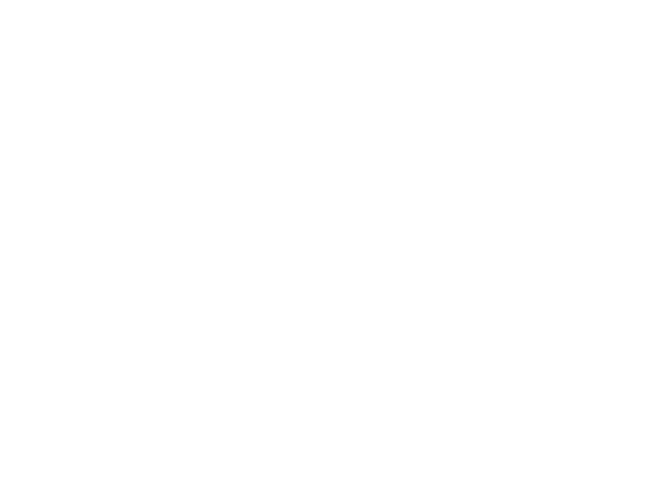

In [42]:
from scapy.all import *
from scapy.layers.inet import IP, ICMP
import networkx as nx
import matplotlib.pyplot as plt

arp_scan_result = srp(Ether(dst="ff:ff:ff:ff:ff:ff")/ARP(pdst="172.20.10.1/20"), timeout=2, verbose=False, iface="Wi-Fi")[0]

print(arp_scan_result)

G = nx.Graph()

for snd, rcv in arp_scan_result:
    print(f"IP-Adresse: {rcv.psrc} hat MAC-Adresse: {rcv.hwsrc}")
    G.add_edge(snd[ARP].psrc, rcv[ARP].hwsrc)

nx.draw(G, with_labels=True)
plt.show()


In [41]:
from scapy.layers.l2 import arping

arping("172.20.10.1/24")

Begin emission:
Finished sending 256 packets.

Received 1 packets, got 1 answers, remaining 255 packets
  92:ec:ea:4c:51:64 unknown 172.20.10.1


(<ARPing: TCP:0 UDP:0 ICMP:0 Other:1>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:255>)